<a href="https://colab.research.google.com/github/brs1977/nlp_stepik_samsung/blob/master/BERT_Classification_IMDB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://github.com/bentrevett/pytorch-sentiment-analysis/blob/master/6%20-%20Transformers%20for%20Sentiment%20Analysis.ipynb

https://github.com/vonsovsky/bert-sentiment/blob/master/notebooks/Sentiment_classifier.ipynb

In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
!pip install pytorch-transformers

In [0]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from pytorch_transformers import BertTokenizer, BertConfig
from pytorch_transformers import AdamW, BertForSequenceClassification
from tqdm import tqdm, trange
import pandas as pd
import io
import numpy as np
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

batch_size = 8 # max_len = 512
gradient_accumulation_steps = 512//batch_size

In [0]:
# https://www.kaggle.com/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews

!unzip /content/drive/My\ Drive/imdb-dataset-of-50k-movie-reviews.zip


import pandas as pd
dataset = pd.read_csv('IMDB Dataset.csv', encoding='utf8')

Archive:  /content/drive/My Drive/imdb-dataset-of-50k-movie-reviews.zip
  inflating: IMDB Dataset.csv        


In [0]:

import torch

import random
import numpy as np

SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

def tokenize_and_cut(sentence):
    tokens = tokenizer.tokenize(sentence) 
    tokens = tokens[:max_input_length-2]
    return tokens

from torchtext import data

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')


100%|██████████| 231508/231508 [00:00<00:00, 2729571.20B/s]


In [0]:
init_token = tokenizer.cls_token
eos_token = tokenizer.sep_token
pad_token = tokenizer.pad_token
unk_token = tokenizer.unk_token

print(init_token, eos_token, pad_token, unk_token)

init_token_idx = tokenizer.convert_tokens_to_ids(init_token)
eos_token_idx = tokenizer.convert_tokens_to_ids(eos_token)
pad_token_idx = tokenizer.convert_tokens_to_ids(pad_token)
unk_token_idx = tokenizer.convert_tokens_to_ids(unk_token)

print(init_token_idx, eos_token_idx, pad_token_idx, unk_token_idx)

max_input_length = tokenizer.max_model_input_sizes['bert-base-uncased']

[CLS] [SEP] [PAD] [UNK]
101 102 0 100


In [0]:
TEXT = data.Field(batch_first = True,
                  use_vocab = False,                  
                  tokenize = tokenize_and_cut,
                  preprocessing = tokenizer.convert_tokens_to_ids,
                  init_token = init_token_idx,
                  eos_token = eos_token_idx,
                  pad_token = pad_token_idx,
                  unk_token = unk_token_idx)

LABEL = data.LabelField(dtype = torch.float)


fields = {
    'review': ('text', TEXT),
    'sentiment': ('label', LABEL)
}


train_data = data.TabularDataset.splits(
                            path = './',
                            train = 'IMDB Dataset.csv',
                            # validation = 'valid.csv',
                            # test = 'test.csv',
                            format = 'csv',
                            fields = fields
)

train_data, test_data = train_data[0].split(.8)
valid_data, test_data = test_data.split(.5)

In [0]:
print(f"Number of training examples: {len(train_data)}")
print(f"Number of validation examples: {len(valid_data)}")
print(f"Number of testing examples: {len(test_data)}")

Number of training examples: 40000
Number of validation examples: 5000
Number of testing examples: 5000


In [0]:
print(vars(train_data.examples[6]))

{'text': [1045, 2469, 2052, 2066, 2000, 2156, 1037, 15218, 1997, 1037, 2039, 6052, 2712, 17157, 2102, 2186, 2007, 1996, 6627, 2027, 2031, 2651, 2009, 2052, 3288, 2067, 1996, 4845, 8277, 1999, 2033, 1012, 1045, 3473, 2039, 2006, 2304, 1998, 2317, 2694, 1998, 2712, 17157, 2102, 2007, 4409, 5302, 3489, 2020, 2026, 5394, 1005, 1055, 2296, 2733, 1012, 2017, 2031, 2026, 3789, 2005, 1037, 12845, 1997, 1037, 2047, 2712, 5690, 1012, 2057, 2342, 1037, 2689, 1997, 6393, 1999, 2694, 1998, 2023, 2052, 2147, 2005, 1037, 2088, 1997, 2104, 2300, 6172, 1012, 2821, 2011, 1996, 2126, 4067, 2017, 2005, 2019, 13307, 2066, 2023, 2000, 3193, 2116, 21386, 2015, 2055, 2694, 1998, 1996, 2116, 5691, 1012, 2061, 2151, 15589, 2126, 1045, 2903, 1045, 1005, 2310, 2288, 2054, 1045, 10587, 2360, 1012, 2052, 2022, 3835, 2000, 3191, 2070, 2062, 4606, 2685, 2055, 2712, 5690, 1012, 2065, 2026, 24468, 2052, 2022, 2184, 3210, 2052, 2017, 2292, 2033, 12040, 1010, 2030, 2681, 2033, 2041, 2000, 2022, 1999, 4797, 1998, 2031, 20

In [0]:
tokens = tokenizer.convert_ids_to_tokens(vars(train_data[0].examples[6])['text'])
print(tokens)



['i', 'sure', 'would', 'like', 'to', 'see', 'a', 'resurrection', 'of', 'a', 'up', 'dated', 'sea', '##hun', '##t', 'series', 'with', 'the', 'tech', 'they', 'have', 'today', 'it', 'would', 'bring', 'back', 'the', 'kid', 'excitement', 'in', 'me', '.', 'i', 'grew', 'up', 'on', 'black', 'and', 'white', 'tv', 'and', 'sea', '##hun', '##t', 'with', 'guns', '##mo', '##ke', 'were', 'my', 'hero', "'", 's', 'every', 'week', '.', 'you', 'have', 'my', 'vote', 'for', 'a', 'comeback', 'of', 'a', 'new', 'sea', 'hunt', '.', 'we', 'need', 'a', 'change', 'of', 'pace', 'in', 'tv', 'and', 'this', 'would', 'work', 'for', 'a', 'world', 'of', 'under', 'water', 'adventure', '.', 'oh', 'by', 'the', 'way', 'thank', 'you', 'for', 'an', 'outlet', 'like', 'this', 'to', 'view', 'many', 'viewpoint', '##s', 'about', 'tv', 'and', 'the', 'many', 'movies', '.', 'so', 'any', 'ole', 'way', 'i', 'believe', 'i', "'", 've', 'got', 'what', 'i', 'wanna', 'say', '.', 'would', 'be', 'nice', 'to', 'read', 'some', 'more', 'plus', 'p

In [0]:
LABEL.build_vocab(train_data)
print(LABEL.vocab.stoi)

defaultdict(<function _default_unk_index at 0x7f6a048522f0>, {'negative': 0, 'positive': 1})


In [0]:
# train_data[0].text
# valid_data[0].text
for batch in test_iterator:
  print(batch)
  break
# valid_iterator


[torchtext.data.batch.Batch of size 128]
	[.text]:[torch.cuda.LongTensor of size 128x69 (GPU 0)]
	[.label]:[torch.cuda.FloatTensor of size 128 (GPU 0)]


In [0]:
BATCH_SIZE = 128

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE, 
    sort_key = lambda x: len(x.text),
    device = device)

#Model

In [0]:
from pytorch_transformers import BertModel

bert = BertModel.from_pretrained('bert-base-uncased')

100%|██████████| 440473133/440473133 [00:06<00:00, 69207090.31B/s]


In [0]:
import torch.nn as nn

class BERTGRUSentiment(nn.Module):
    def __init__(self,
                 bert,
                 hidden_dim,
                 output_dim,
                 n_layers,
                 bidirectional,
                 dropout):
        
        super().__init__()
        
        self.bert = bert
        
        embedding_dim = bert.config.to_dict()['hidden_size']
        
        self.rnn = nn.GRU(embedding_dim,
                          hidden_dim,
                          num_layers = n_layers,
                          bidirectional = bidirectional,
                          batch_first = True,
                          dropout = 0 if n_layers < 2 else dropout)
        
        self.out = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text):
        
        #text = [batch size, sent len]
                
        with torch.no_grad():
            embedded = self.bert(text)[0]
                
        #embedded = [batch size, sent len, emb dim]
        
        _, hidden = self.rnn(embedded)
        
        #hidden = [n layers * n directions, batch size, emb dim]
        
        if self.rnn.bidirectional:
            hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1))
        else:
            hidden = self.dropout(hidden[-1,:,:])
                
        #hidden = [batch size, hid dim]
        
        output = self.out(hidden)
        
        #output = [batch size, out dim]
        
        return output

In [0]:
HIDDEN_DIM = 256
OUTPUT_DIM = 1
N_LAYERS = 2
BIDIRECTIONAL = True
DROPOUT = 0.25

model = BERTGRUSentiment(bert,
                         HIDDEN_DIM,
                         OUTPUT_DIM,
                         N_LAYERS,
                         BIDIRECTIONAL,
                         DROPOUT)

In [0]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 112,241,409 trainable parameters


In [0]:
#freeze paramers
for name, param in model.named_parameters():                
    if name.startswith('bert'):
        param.requires_grad = False

In [0]:
print(f'The model has {count_parameters(model):,} trainable parameters')

for name, param in model.named_parameters():                
    if param.requires_grad:
        print(name)

The model has 2,759,169 trainable parameters
rnn.weight_ih_l0
rnn.weight_hh_l0
rnn.bias_ih_l0
rnn.bias_hh_l0
rnn.weight_ih_l0_reverse
rnn.weight_hh_l0_reverse
rnn.bias_ih_l0_reverse
rnn.bias_hh_l0_reverse
rnn.weight_ih_l1
rnn.weight_hh_l1
rnn.bias_ih_l1
rnn.bias_hh_l1
rnn.weight_ih_l1_reverse
rnn.weight_hh_l1_reverse
rnn.bias_ih_l1_reverse
rnn.bias_hh_l1_reverse
out.weight
out.bias


In [0]:
import torch.optim as optim

optimizer = optim.Adam(model.parameters())
criterion = nn.BCEWithLogitsLoss()

model = model.to(device)
criterion = criterion.to(device)

      

In [0]:
from IPython.display import clear_output

def binary_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """

    #round predictions to the closest integer
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float() #convert into float for division 
    acc = correct.sum() / len(correct)
    return acc

def train(model, iterator, optimizer, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    train_loss_set = []

    model.train()
    
    for batch in iterator:
        
        optimizer.zero_grad()
        
        predictions = model(batch.text).squeeze(1)
        
        loss = criterion(predictions, batch.label)
        
        train_loss_set.append(loss.item())  

        acc = binary_accuracy(predictions, batch.label)
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()

        # Рисуем график
        clear_output(True)
        plt.plot(train_loss_set)
        plt.title("Training loss")
        plt.xlabel("Batch")
        plt.ylabel("Loss")
        plt.show()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

def evaluate(model, iterator, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
    
        for batch in iterator:

            predictions = model(batch.text).squeeze(1)
            
            loss = criterion(predictions, batch.label)
            
            acc = binary_accuracy(predictions, batch.label)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs      

#Train

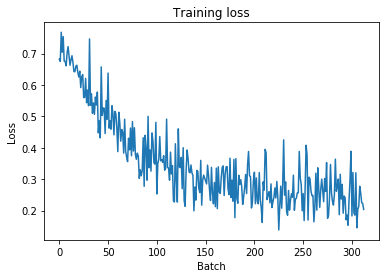

TypeError: ignored

In [0]:
N_EPOCHS = 1

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion)
        
    end_time = time.time()
        
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
        
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut6-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

In [0]:
valid_loss, valid_acc = evaluate(model, valid_iterator, criterion)

In [0]:
print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

	 Val. Loss: 0.224 |  Val. Acc: 90.80%


In [0]:
model.load_state_dict(torch.load('tut6-model.pt'))

test_loss, test_acc = evaluate(model, test_iterator, criterion)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')



Test Loss: 0.216 | Test Acc: 91.33%


In [0]:
def predict_sentiment(model, tokenizer, sentence):
    model.eval()
    tokens = tokenizer.tokenize(sentence)
    tokens = tokens[:max_input_length-2]
    indexed = [init_token_idx] + tokenizer.convert_tokens_to_ids(tokens) + [eos_token_idx]
    tensor = torch.LongTensor(indexed).to(device)
    tensor = tensor.unsqueeze(0)
    prediction = torch.sigmoid(model(tensor))
    return prediction.item()

predict_sentiment(model, tokenizer, "This film is terrible")    

0.013646318577229977